In [533]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [541]:
def train_test_split(X, Y, train_size):

    d, N = X.shape

    #shuffle data
    indexes = np.arange(N)
    #np.random.seed(42)
    np.random.shuffle(indexes)

    #get indexes
    N_train = int(N*train_size)
    train_idxs = indexes[:N_train]
    test_idxs = indexes[N_train:]

    #partition data
    return X[:, train_idxs], X[:, test_idxs], Y[train_idxs], Y[test_idxs]


* Load and pre-process the dataset as did in the previous exercise, to get the matrix `X` with shape `(784, 42000)`
* Choose a number of digits and extract from `X` and `Y` the sub-dataset containing only the considered digits.
* Randomly sample a training set with $N_{train}$ datapoints from  `X` and `Y`. This has to be done **after** filtering out the selected digits from `X` and `Y`.

In [542]:
#load data
data = pd.read_csv('./train.csv')
data = data.to_numpy()
print(f"Data shape: {data.shape}")

#split X an Y
X = data[:, 1:].T
Y = data[:, 0]

#filter the given digits
digits = [3,6,9]
mask = np.isin(Y, digits)
filtered_X = X[:, mask]
filtered_Y = Y[mask]


#create train and test datasets
Xtrain, Xtest, Ytrain, Ytest = train_test_split(filtered_X, filtered_Y, train_size=0.8)
print(f"Xtrain shape: {Xtrain.shape} --- Xtest shape: {Xtest.shape}  \nytrain shape: {Ytrain.shape} --- ytest shape: {Ytest.shape}")

Data shape: (42000, 785)
Xtrain shape: (784, 10140) --- Xtest shape: (784, 2536)  
ytrain shape: (10140,) --- ytest shape: (2536,)


* Implement the algorithms computing the PCA of `X_train` with a fixed value of $k$. Visualize the results (for $k = 2$) and the position of the centroid of each cluster. The clusters are identified by projecting `X_train` via PCA to its low-dimension version `Z_train`, and then splitting it into sets (say, `Z1`, `Z2`, `Z3`) based on the digit that was represented in that position before the PCA projection. Each set `Z1`, `Z2`, `Z3` represents a cluster, of which we can easily compute the centroid.


In [545]:
def PCA(data, k):

    d, N = data.shape

    #compute the centroid
    centroid = np.mean(data, axis=1)
    centroid = np.reshape(centroid,(d,1)) #column vector

    #center the data around zero
    X_c = data - centroid

    #SVD decomposition
    U, s, VT = np.linalg.svd(data, full_matrices=False)

    #reduced U given k
    U_k = U[:, :k] # shape (num_features, k)

    #project the data
    Z_k = U_k.T@X_c # shape (k, num_samples)

    return U_k, Z_k

U_k, Z_train = PCA(Xtrain, 2) # PCA

# compute the centroid for each class
centroids = {c:np.mean(Z_train[:, Ytrain==c], axis=1) for c in digits}

print(f"Z_train shape: {Z_train.shape}")
print(f"Centroids: {centroids}")


Z_train shape: (2, 10140)
Centroids: {3: array([ -24.57148153, -718.00937289]), 6: array([-40.62018347, 616.40315971]), 9: array([ 64.77588365, 133.7275418 ])}


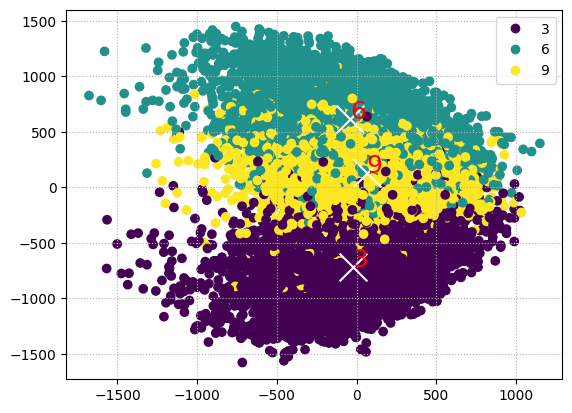

In [562]:
#this function works only when k=2
def visualize(data, labels, centroids, title=""):
    ax = plt.scatter(data[0], data[1], c=labels)
    for c, centroid in centroids.items():
        plt.scatter(centroid[0], centroid[1],color='white', marker='x', s=400)
        plt.text(centroid[0], centroid[1], c, color='red', size=18)
    plt.title(title)
    plt.legend(*ax.legend_elements())
    plt.grid(linestyle=':')

visualize(Z_train, Ytrain, centroids)

* Compute, for each cluster, the average distance from its centroid. Which property of PCA projection does this quantity measure?

In [575]:
#mean_distances = {digit:np.mean(np.linalg.norm(Z_train[:, Ytrain==digit]-centroids[digit].reshape(-1,1), 2, axis=0)) for digit in digits}
mean_distances = {digit:np.mean(np.linalg.norm(Z_train.T[Ytrain==digit]-centroids[digit], 2, axis=1)) for digit in digits}
print(mean_distances)

{3: 469.6260523905924, 6: 470.0234487635701, 9: 387.6176586736628}


This quantity measures how good is PCA in keeping images semantically similar close to each other. Small avarage distances from the centroinds represent a better ability of PCA in projecting data in a lower dimensional space and retaining as much information as possible at the same time.

* By keeping the **same** projection matrix `P` from the train set, project the test set `X_test` on the low-dimensional space.
* Consider the clusters in `X_test` by considering the informations on `Y_test`, similarly to what we did on the previous point. Consider the centroids computed from the training set. For each cluster in the test set, compute the average distance to the corresponding centroid (from the train set). Comment the results;

{3: 469.0461098241442, 6: 482.05931558312665, 9: 383.2148231578013}


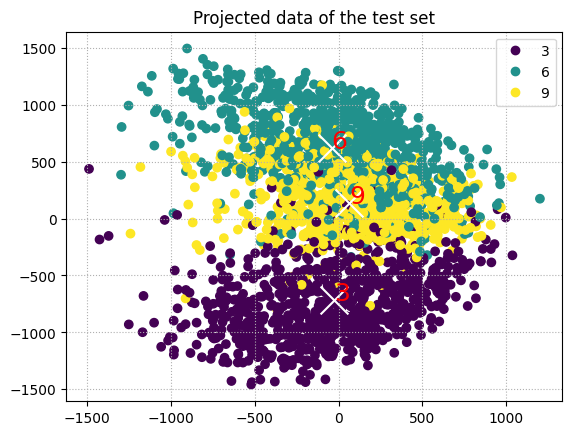

In [576]:
d, N = Xtest.shape

#compute the centroid and center data
centroid = np.mean(Xtest, axis=1)
centroid = np.reshape(centroid,(d,1))
X_c = Xtest - centroid

#project the data using the previous projection matrix
Z_test = U_k.T@X_c # (d, 2).T x (d, N) --> (2, N)


mean_distances = {c:np.mean(np.linalg.norm(Z_test.T[Ytest==c]-centroids[c], 2, axis=1)) for c in digits}
print(mean_distances)

visualize(Z_test, Ytest, centroids, f'Projected data of the test set') #using centroids of the training data

As we can see, the avarage distances of the test data from the centroids are pretty similar to those of the training data.

* Define a classification algorithm in this way: given a new observation `x`, compute the distance between `x` and each cluster centroid computed on the training set. Assign `x` to the class corresponding the the closer centroid. Compute the misclassification rate of this algorithm on the test set;

In [579]:
'''Give a set of test images, this algorithm compute the distance of each image with each centroid.
    Then assigne the image to th e class of the closest centroid.'''


def PCA_classifier(test_data, centroids, projection_matrix):

    d, N = test_data.shape

    #center data around 0
    centroid = np.mean(test_data, axis=1)
    centroid = np.reshape(centroid,(d,1))
    X_c = test_data - centroid

    #project data
    proj_data = projection_matrix.T @ X_c

    sorted_classes = sorted(centroids.keys())  # Sort keys to ensure consistent order
    distances = []

    # Compute distance of each data point from each centroid
    for c in sorted_classes:
        centroid_coords = centroids[c]  # Get centroid coordinates
        dist = np.linalg.norm(proj_data.T - centroid_coords,2, axis=1)  # Distance for all test points
        distances.append(dist)

    # convert to numpy 
    distances = np.array(distances)

    # Find closest classes
    closest_classes = np.argmin(distances, axis=0)

    # Map indices to class labels using sorted_classes
    #predictions = np.array([sorted_classes[idx] for idx in closest_classes])
    predictions = np.array(sorted_classes)[closest_classes]


    return proj_data, predictions

def accuracy(pred, y_true):
    return np.mean(pred == y_true)

proj, pred = PCA_classifier(Xtest, centroids, U_k)
acc  = accuracy(pred, Ytest)
print(acc)

0.7886435331230284


* Repeat this experiment for different values of $k$ and different digits. What do you observe?

In [587]:
k_vals = [2,3,4,6,10,15,20,35,60,100,150]

digits_set = [[0,1,2], [4,9,7], [3,4,9], [2,7,0], [1,3,4,7,9], [0,1,2,3,4]]

results = []

for digits in digits_set:
    print('===============')
    accuracies = []
    for k in k_vals:

        print(f'computing {digits} with k = {k}', end=' --- ')

        #filter data for the given digits
        mask = np.isin(Y, digits)
        filtered_X = X[mask].T
        filtered_Y = Y[mask]

        #split train and test
        Xtrain, Xtest, Ytrain, Ytest = train_test_split(filtered_X, filtered_Y, train_size=0.67)

        # Project data
        U_k, Z_train = PCA(Xtrain, k)
        centroids = {c:np.mean(Z_train.T[Ytrain==c], axis=0) for c in digits}

        # Classify to the nearest centroid
        proj, pred = PCA_classifier(Xtest, centroids, U_k)

        # Compute the accuracy
        acc  = accuracy(pred, Ytest)
        accuracies.append(acc)
        print(f'Accuracy: {acc}')

    results.append([digits, accuracies, proj, centroids, Ytest])
    

computing [0, 1, 2] with k = 2
Accuracy: 0.8973880597014925
computing [0, 1, 2] with k = 3
Accuracy: 0.9085820895522388
computing [0, 1, 2] with k = 4
Accuracy: 0.9202425373134329
computing [0, 1, 2] with k = 6
Accuracy: 0.929570895522388
computing [0, 1, 2] with k = 10
Accuracy: 0.9407649253731343
computing [0, 1, 2] with k = 15
Accuracy: 0.9391324626865671
computing [0, 1, 2] with k = 20
Accuracy: 0.941464552238806
computing [0, 1, 2] with k = 35
Accuracy: 0.941231343283582
computing [0, 1, 2] with k = 60
Accuracy: 0.9365671641791045
computing [0, 1, 2] with k = 100
Accuracy: 0.9428638059701493
computing [0, 1, 2] with k = 150
Accuracy: 0.9388992537313433
computing [4, 9, 7] with k = 2
Accuracy: 0.46063651591289784
computing [4, 9, 7] with k = 3
Accuracy: 0.6410624551328069
computing [4, 9, 7] with k = 4
Accuracy: 0.7310361330461833
computing [4, 9, 7] with k = 6
Accuracy: 0.7504187604690117
computing [4, 9, 7] with k = 10
Accuracy: 0.8377602297200287
computing [4, 9, 7] with k = 15


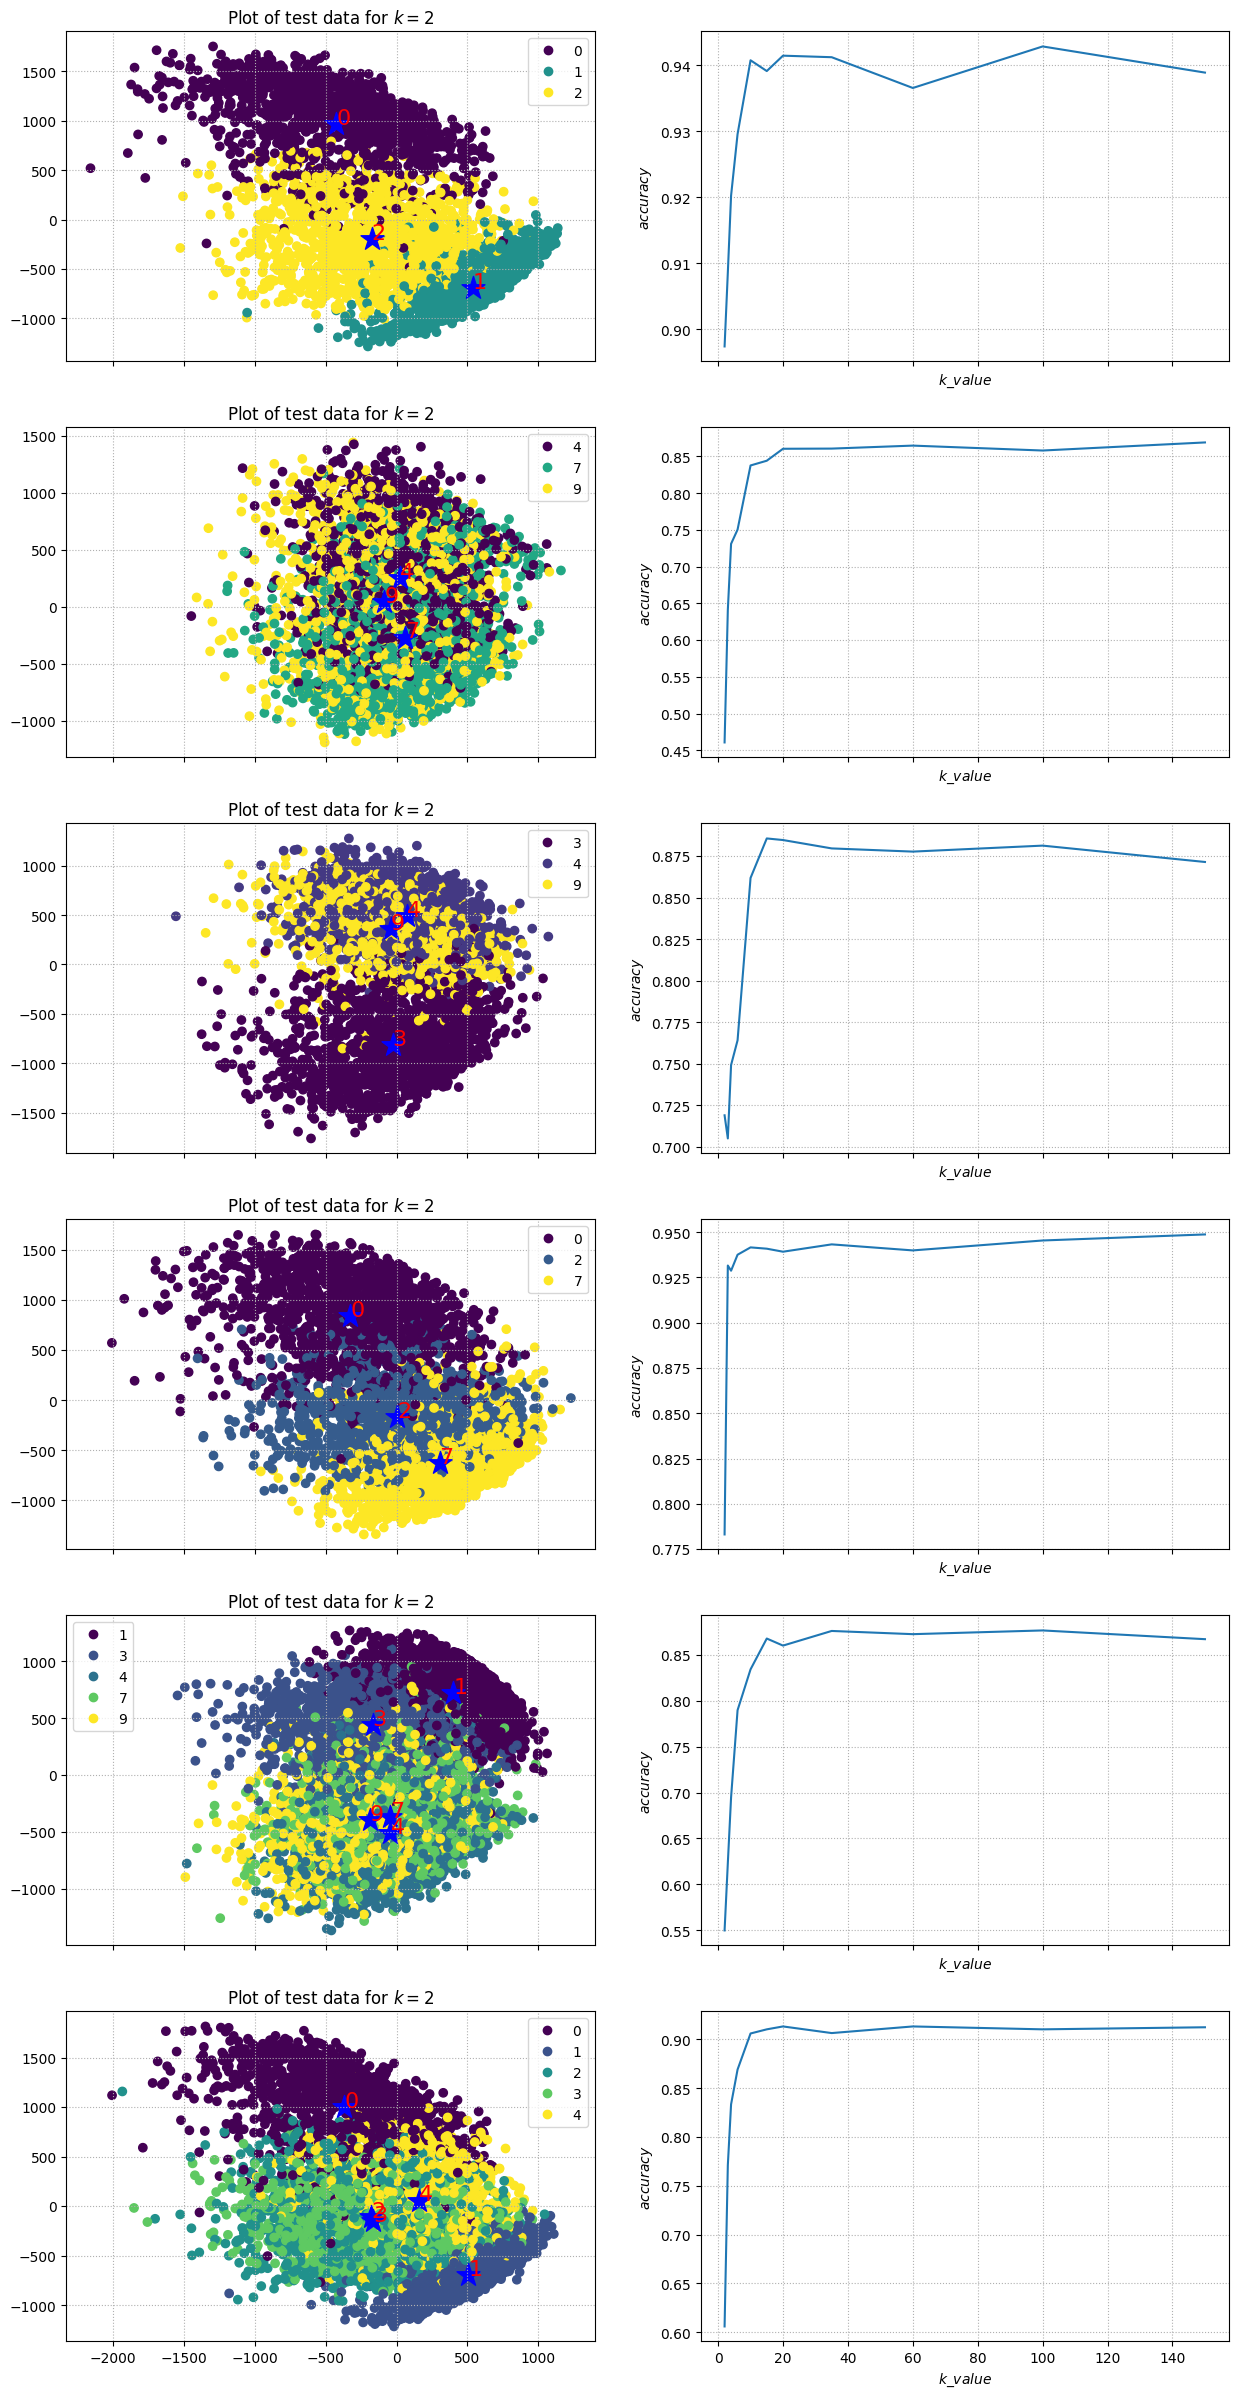

In [595]:
fig, axs = plt.subplots(figsize=(15,30), nrows=len(digits_set), ncols=2, sharex='col')

for i in range(axs.shape[0]):

    digits, accuracies, proj, centroids, Ytest = results[i]

    ax = axs[i][0]
    scatter = ax.scatter(proj[0], proj[1], c=Ytest)
    for c, centroid in centroids.items():
        ax.scatter(centroid[0], centroid[1],color='blue', marker='*', s=300)
        ax.text(centroid[0], centroid[1], c, color='red', size=16)
    ax.legend(*scatter.legend_elements())
    ax.grid(linestyle=':')
    ax.set_title('Plot of test data for $k = 2$')




    ax = axs[i][1]
    ax.plot(k_vals, accuracies)
    ax.set_ylabel('$accuracy$')
    ax.set_xlabel('$k\_value$')
    ax.grid(linestyle=':')



As we can see from the plot, in most of the cases $k=10$ or $15$ is sufficient for reaching the top accuracy. Moreover, it should be noted that for well separeted classes we reach an accuracy higher than $0.9$. It is not true for classes close each other.

* Compare this classification algorithm with the one defined in the previous exercise. Which performs better?

In my opinion PCA works slightely better because also in the case of very similar digits (like 4, 9 and 7) it reaches higher accuracies if compared with SVD.